In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'SVHN_1x64x64_train.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    del save  # hint to help gc free up memory
    print('train set', train_dataset.shape, train_labels.shape)

train set (97722, 1, 64, 64) (97722, 6)


In [3]:
c4 = []

for i in range(97722):
    categ = train_labels[i][0]
    if(categ == 4):
        c4.append(i)

print(len(c4))

6227


In [4]:
c4_data = train_dataset[c4]
c4_target = train_labels[c4]
print(c4_data.shape)
print(c4_target.shape)

(6227, 1, 64, 64)
(6227, 6)


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, padding=(1, 1))
        self.conv2 = nn.Conv2d(20, 40, 3, padding=(1, 1))
        self.conv3 = nn.Conv2d(40, 80, 3, padding=(1, 1))
        self.conv4 = nn.Conv2d(80, 120, 3, padding=(1, 1))
        self.conv5 = nn.Conv2d(120, 160, 3, padding=(1, 1))
        self.conv6 = nn.Conv2d(160, 200, 3, padding=(1, 1))
        self.conv7 = nn.Conv2d(200, 240, 3, padding=(1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.FC = nn.Linear(960, 1080)
        self.digitlength = nn.Linear(1080, 7)
        self.digit1 = nn.Linear(1080, 10)
        self.digit2 = nn.Linear(1080, 10)
        self.digit3 = nn.Linear(1080, 10)
        self.digit4 = nn.Linear(1080, 10)
        self.digit5 = nn.Linear(1080, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = x.view(-1, 960)
        x = self.FC(x)
        yl = self.digitlength(x)
        y1 = self.digit1(x)
        y2 = self.digit2(x)
        y3 = self.digit3(x)
        y4 = self.digit4(x)
        y5 = self.digit5(x)
        return [yl, y1, y2, y3, y4, y5]

In [8]:
net = Net()
f = open('c3_leg_ep_20.pkl', 'rb')
net.load_state_dict(torch.load(f))
f.close()
net.cuda()

Net (
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(80, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(120, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(160, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(200, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (FC): Linear (960 -> 1080)
  (digitlength): Linear (1080 -> 7)
  (digit1): Linear (1080 -> 10)
  (digit2): Linear (1080 -> 10)
  (digit3): Linear (1080 -> 10)
  (digit4): Linear (1080 -> 10)
  (digit5): Linear (1080 -> 10)
)

In [ ]:
for param in net.parameters():
    print(param)

In [10]:
for param in net.parameters():
    if(param.grad is not None):
        print(param)

In [12]:
c4_data_tensor = torch.from_numpy(c4_data)
c4_target_tensor = torch.from_numpy(c4_target).type(torch.LongTensor)
print(c4_data_tensor.type(), c4_data_tensor.size())
print(c4_target_tensor.type(), c4_target_tensor.size())

torch.FloatTensor torch.Size([6227, 1, 64, 64])
torch.LongTensor torch.Size([6227, 6])


In [13]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [16]:
num_epochs = 20
batch_size = 64
num_train =  c4_data.shape[0]
iter_per_epoch = num_train // batch_size
print_every = 40
print(iter_per_epoch)

97


In [17]:
epoch_losses = {i:[] for i in range(num_epochs)}
loss_history = []

In [18]:
import time

In [22]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 110)

    i = 0
    rng_state = torch.get_rng_state()
    new_idxs = torch.randperm(num_train)
    c4_X = c4_data_tensor[new_idxs]
    c4_Y = c4_target_tensor[new_idxs]
    
    t1 = time.time()
    for t in range(iter_per_epoch):
        
        X_batch = c4_X[i: i+batch_size]
        Y_batch = c4_Y[i: i+batch_size][:,0:5]
        i += batch_size

        Y_batch = Variable(Y_batch.cuda())
        X_batch = Variable(X_batch.cuda())
        
        optimizer.zero_grad()
        
        outputs = net(X_batch)
        
        lossl = objective(outputs[0], Y_batch[:, 0])
        loss1 = objective(outputs[1], Y_batch[:, 1])
        loss2 = objective(outputs[2], Y_batch[:, 2])
        loss3 = objective(outputs[3], Y_batch[:, 3])
        loss4 = objective(outputs[4], Y_batch[:, 4])
        final_loss = lossl + loss1 + loss2 + loss3 + loss4
        
        final_loss.backward()
        
        optimizer.step()
        
        loss_history.append(final_loss.data[0])
        epoch_losses[epoch].append(final_loss.data[0])
        
        if (t % print_every == 0):
            print('Iteration : ', t+1, ' / ', iter_per_epoch)
            print('loss : ', final_loss.data[0])
            print('lossl : ', lossl.data[0], 'loss1 : ', loss1.data[0], 'loss2 : ', loss2.data[0], 'loss3 : ', loss3.data[0])
            print('loss4 : ', loss4.data[0])
    t2 = time.time()
    print("time taken : ", t2-t1)
    print('-' * 110)
        

Epoch 0/19
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  97
loss :  5.085860252380371
lossl :  0.00041174888610839844 loss1 :  0.3406800925731659 loss2 :  1.070333480834961 loss3 :  1.6604108810424805
loss4 :  2.014024019241333
Iteration :  41  /  97
loss :  3.400709629058838
lossl :  0.00016592442989349365 loss1 :  0.2866703271865845 loss2 :  0.6421934366226196 loss3 :  1.0729002952575684
loss4 :  1.3987797498703003
Iteration :  81  /  97
loss :  3.4856481552124023
lossl :  6.298720836639404e-05 loss1 :  0.34067440032958984 loss2 :  0.7340823411941528 loss3 :  1.1426481008529663
loss4 :  1.2681803703308105
time taken :  147.5708909034729
--------------------------------------------------------------------------------------------------------------
Epoch 1/19
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  97
loss :  2.7905

KeyboardInterrupt: 

In [25]:
f = open("c3_leg_ep_20.pkl", "bw")
torch.save(net.state_dict(), f)
f.close()

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

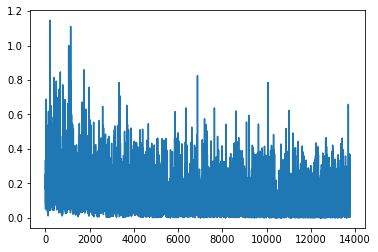

In [35]:
plt.figure()
plt.plot(loss_history)